In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import numpy as np
import architectures
import importlib

device = torch.device('xpu')


In [2]:
torch.xpu.is_available()

True

### Image generation with non-variational autoencoder

In [3]:
rnae_filepaths = sorted([f for f in os.listdir() if f[:4] == 'rnae'], reverse=True)
rnae_fp = rnae_filepaths[0]
mrnae_filepaths = sorted([f for f in os.listdir() if f[:5] == 'mrnae'], reverse=True)
mrnae_fp = mrnae_filepaths[0]

print(rnae_fp, mrnae_fp)
mrnae = architectures.MnistResNetAutoEncoder()
mrnae.load_state_dict(torch.load('mrnae_20250802_083036.pt', map_location=torch.device('cpu')))

rnae_20250802_053836.pt mrnae_20250802_083036.pt


<All keys matched successfully>

In [4]:
from torchvision import datasets, transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize pixel values
])
mnist_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=1000, shuffle=False)

In [5]:
embds = []
for idx, batch in enumerate(mnist_test_loader):
  embd, repr = mrnae(batch[0])
  embds.append(embd)

embd_all = torch.cat(embds)

In [6]:
embd_mu = embd_all.mean(dim=0)
embd_sig = embd_all.std(dim=0)

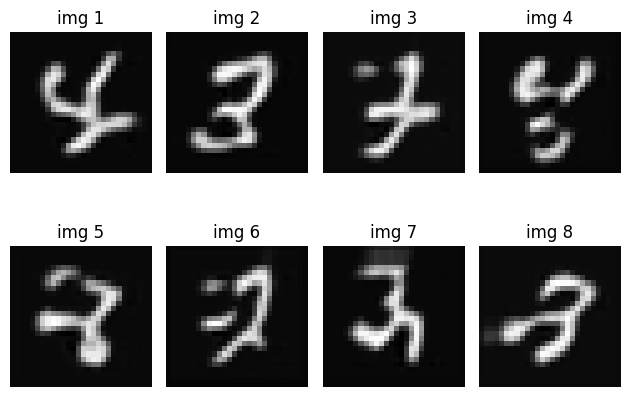

In [7]:
samples = [torch.normal(mean=embd_mu, std=embd_sig) for i in range(8)]
imgs = [mrnae.decode(s.unsqueeze(0)).squeeze(0).squeeze(0).detach().numpy() for s in samples]

fig, axes = plt.subplots(nrows=2, ncols=4)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(imgs[i], cmap='gray')
    ax.set_title(f'img {i + 1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

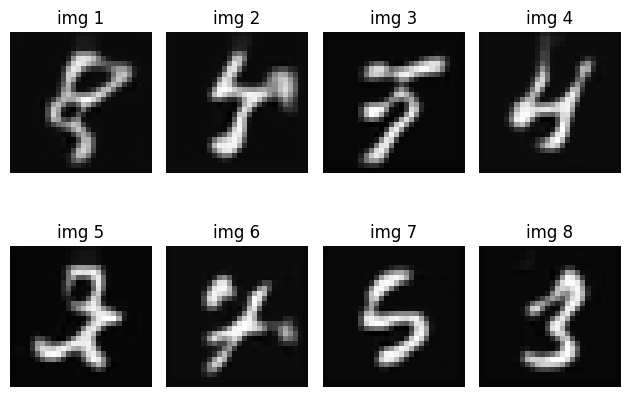

In [8]:
samples = torch.randn((8, 32))
mrnae.to(device=torch.device('cpu'))
imgs = [mrnae.decode(s.unsqueeze(0)).squeeze(0).squeeze(0).detach().numpy() for s in samples]

fig, axes = plt.subplots(nrows=2, ncols=4)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(imgs[i], cmap='gray')
    ax.set_title(f'img {i + 1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Training a VAE

In [13]:
importlib.reload(architectures)

device = torch.device('xpu')

mvae = architectures.MnistResNetVAE(device=device)

# use pre-trained encoder and decoder, except for final linear projection into embedding space
mvae.resnet = nn.Sequential(*list(mrnae.resnet.children())[:-1])
mvae.unresnet = nn.Sequential(*list(mrnae.unresnet.children()))

mvae.to(device)

# don't update gradients for these
for param in mvae.resnet.parameters():
  param.requires_grad = False
for param in mvae.unresnet.parameters():
  param.requires_grad = False

def vae_loss(x_repr, x, mu, logvar, lmbda=0.5):
  BCE = lmbda * F.binary_cross_entropy(x_repr, x, reduction='sum')
  KLD = (1 - lmbda) * -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return BCE, KLD

In [16]:
#train
mse_loss = nn.MSELoss()
kl_div_loss = nn.KLDivLoss()

lr = 1e-5
weight_decay = 1e-3
optimizer = optim.Adam(params=mvae.parameters(), lr=lr, weight_decay=1e-3)

for epoch in range(50):
  for idx, (inputs, _) in enumerate(mnist_train_loader, 0):
    inputs = inputs.to(device)
    emb_mu, emb_logvar, sampled, X_repr = mvae(inputs)
    optimizer.zero_grad()
    x_repr_softmax = F.softmax(X_repr.view(-1, 28 * 28), dim=1)
    inputs_softmax = F.softmax(inputs.view(-1, 28 * 28), dim=1)
    BCE, KLD = vae_loss(x_repr=x_repr_softmax, x=inputs_softmax, mu=emb_mu, logvar=emb_logvar, lmbda=0.1)
    loss = BCE + KLD
    loss.backward()
    optimizer.step()

    if idx % 200 == 0:
      print(f'epoch {epoch}, batch {idx}: loss = {loss.item():.2f}, BCE = {BCE:.2f}, KLD = {KLD:.2f}')

epoch 0, batch 0: loss = 49.82, BCE = 49.82, KLD = 0.00
epoch 0, batch 200: loss = 50.00, BCE = 49.99, KLD = 0.00
epoch 0, batch 400: loss = 50.07, BCE = 50.06, KLD = 0.01
epoch 0, batch 600: loss = 49.98, BCE = 49.97, KLD = 0.01
epoch 0, batch 800: loss = 50.03, BCE = 50.03, KLD = 0.01
epoch 1, batch 0: loss = 50.11, BCE = 50.10, KLD = 0.01
epoch 1, batch 200: loss = 49.99, BCE = 49.98, KLD = 0.01
epoch 1, batch 400: loss = 50.39, BCE = 50.38, KLD = 0.01
epoch 1, batch 600: loss = 49.99, BCE = 49.99, KLD = 0.01
epoch 1, batch 800: loss = 50.02, BCE = 50.01, KLD = 0.01
epoch 2, batch 0: loss = 50.21, BCE = 50.20, KLD = 0.01
epoch 2, batch 200: loss = 49.72, BCE = 49.71, KLD = 0.01
epoch 2, batch 400: loss = 50.35, BCE = 50.34, KLD = 0.01
epoch 2, batch 600: loss = 50.44, BCE = 50.43, KLD = 0.01
epoch 2, batch 800: loss = 49.97, BCE = 49.96, KLD = 0.01
epoch 3, batch 0: loss = 49.96, BCE = 49.95, KLD = 0.01
epoch 3, batch 200: loss = 50.00, BCE = 49.99, KLD = 0.01
epoch 3, batch 400: lo

KeyboardInterrupt: 

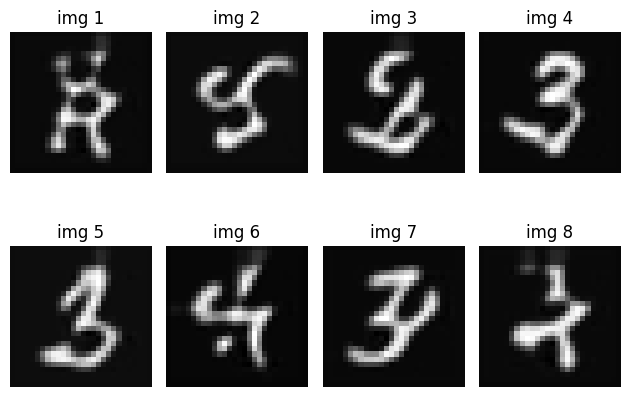

In [19]:
samples = torch.randn((8, 32))
mvae.to(torch.device('cpu'))
imgs = [mvae.decode(s.unsqueeze(0)).squeeze(0).squeeze(0).detach().numpy() for s in samples]

fig, axes = plt.subplots(nrows=2, ncols=4)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(imgs[i], cmap='gray')
    ax.set_title(f'img {i + 1}')
    ax.axis('off')

plt.tight_layout()
plt.show()